### Hate Speech Detection using PyTorch and Hugging Face Transformers
Hate speech detection task to determine if a piece of text contains hateful content.

Data: A twitter corpus study of US Elections 2020 on the basis of Offensive speech and Stance detection.

Data URL: https://www.ims.uni-stuttgart.de/forschung/ressourcen/korpora/stance-hof/

#### GPU Setup

In [1]:
import torch

# If GPU is available
if torch.cuda.is_available():
    # PyTorch will use GPU
    device = torch.device("cuda")
    print("The GPU that is used: ", torch.cuda.get_device_name(0))

# If GPU is not available
else:
    # PyTorch will use CPU
    device = torch.device("cpu")
    print("No GPU available, CPU is used.")

The GPU that is used:  NVIDIA GeForce RTX 3060 Ti


In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from collections import Counter
import re

from torch import nn, optim
from torch.nn import functional as F

#### Read Data
Data we have is provided in a .tsv format. Just for the sake of ease, we will convert it to a readable .csv format first.

In [3]:
train_tsv = './data/train.tsv'
test_tsv = './data/test.tsv'

# Reading given tsv file
train_csv = pd.read_table(train_tsv, sep = '\t')
test_csv = pd.read_table(test_tsv, sep = '\t')

# Converting the tsv files into csv
train_csv.to_csv('./data/train.csv', index = False)
test_csv.to_csv('./data/test.csv', index = False)

print("Conversion completed successfully.")


Conversion completed successfully.


In [4]:
augmented_data = pd.read_csv('./data/aggression_parsed_dataset.csv')

In [5]:
train_data_aug = pd.DataFrame([augmented_data.Text, augmented_data.oh_label]).transpose()

In [6]:
train_data_aug = train_data_aug.rename(columns = {'Text': 'text', 'oh_label': 'HOF'})

Now the data is converted into .csv files, let's check the data out.

In [7]:
labels = {0: 'Non-Hateful', 1: 'Hateful'}
train_data_aug['HOF'] = train_data_aug['HOF'].apply(lambda x: labels[x])

The guidelines from the data already confirmed that the data contained 5 columns. But, we will not be using the three columns (Trump, Biden, and West) and will be only using 'text' and 'HOF' where 'HOF' column is the label for Hateful/Non-Hateful. Initially, I was thinking of using all the columns but I was thinking of situations where it could be in favor of all the three columns but can be labeled hateful.

In [8]:
# Data load function
def load_data(filename, sample_size = 10):
    df = pd.read_csv(filename)
    print("Sample of {} data".format(filename))
    display(df.sample(10))
    return df

In [9]:
# Loading data into pandas dataframe
train_df = load_data('./data/train.csv')
test_df = load_data('./data/test.csv')


Sample of ./data/train.csv data


,text,Trump,Biden,West,HOF
771,.@meenaharris is joining Granite State Women f...,Neither,Neutral mentions,Neither,Non-Hateful
762,@realDonaldTrump You are loved sir we are with...,Favor,Neither,Neither,Non-Hateful
987,Democrats are fighting for you. Republicans? T...,Against,Favor,Neither,Non-Hateful
584,Retweet if you're voting for Biden!,Neither,Favor,Neither,Non-Hateful
1370,@kenolin1 @GRINNGAB @JoeBiden @realDonaldTrump...,Against,Favor,Neither,Non-Hateful
1793,"Poor pic of Dr. Biden, better of Kamala, blurr...",Neither,Neutral mentions,Neither,Non-Hateful
936,@ddale8 His campaign does not revolve around o...,Against,Neutral mentions,Neither,Non-Hateful
529,@KamalaHarris I'm still voting Biden but hones...,Neither,Mixed,Neither,Non-Hateful
1408,"@gtconway3d Next year, George. Next year. #Bid...",Neither,Favor,Neither,Non-Hateful
830,@JohnCornyn I'm going to go ahead and muzzle/m...,Against,Favor,Neither,Hateful


Sample of ./data/test.csv data


,text,Trump,Biden,West,HOF
127,@robbystarbuck he has already had his fare sha...,Favor,Against,Neither,Non-Hateful
122,@GovNedLamont @Mike_Pence @WhiteHouse We agree...,Favor,Neither,Neither,Non-Hateful
85,Avengers Assemble baby!! Some of the Avengers ...,Neither,Neutral mentions,Neither,Non-Hateful
96,IM ALMOST AT 1000 followers! YaY! [NEWLINE][NE...,Favor,Neither,Neither,Non-Hateful
156,@realDonaldTrump uses military people who have...,Against,Favor,Neither,Hateful
583,“My name is Dominique Lee and this November I'...,Neither,Favor,Neither,Non-Hateful
591,@JackPosobiec Along the route #MAGA2020 https:...,Favor,Neither,Neither,Non-Hateful
342,Y'all @JoeBiden is about to get destroyed at t...,Favor,Against,Neither,Non-Hateful
209,Ballot arrived! Can’t wait to fill it out and ...,Against,Favor,Neither,Non-Hateful
592,@ScottNevins We only win if ALL Democrats -Pro...,Neither,Favor,Neither,Non-Hateful


Now, we chop off the middle three columns.

In [10]:
train_df = pd.concat([train_df.iloc[:, 0], train_df.iloc[:, -1]], axis = 1)
test_df = pd.concat([test_df.iloc[:, 0], test_df.iloc[:, -1]], axis = 1)

In [11]:
train_df = pd.concat([train_df, train_data_aug])

Guideline of the dataset claims there can be duplicates in the dataset. Thus, we will check if there is any.

In [12]:
print(len(train_df['text'].drop_duplicates()) == len(train_df))
print(len(test_df['text'].drop_duplicates()) == len(test_df))

False
True


Since, train_df is false, we can confirm there are duplicates in train_df.

In [13]:
train_df = train_df.drop_duplicates(subset = ['text'])

In [15]:
print(len(train_df['text'].drop_duplicates()) == len(train_df))
print(len(test_df['text'].drop_duplicates()) == len(test_df))

True
True


Now, we have removed the duplicates from the train_df.

#### Data Analysis and Visualization

##### Class Count

In [16]:
class_counts = train_df['HOF'].value_counts()
print(class_counts)

HOF
Non-Hateful    103004
Hateful         15057
Name: count, dtype: int64


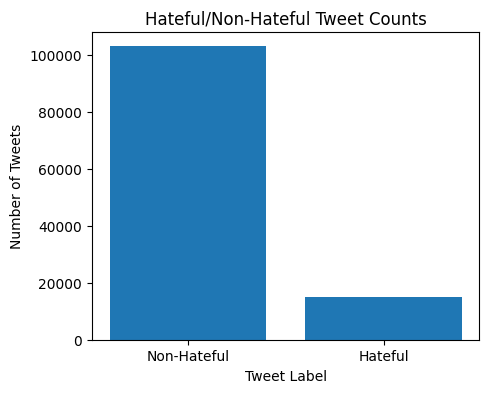

In [17]:
matplotlib.rcParams['figure.figsize'] = (5, 4)
plt.bar(x = train_df['HOF'].unique(), height = train_df['HOF'].value_counts().values)
plt.title("Hateful/Non-Hateful Tweet Counts")
plt.ylabel("Number of Tweets")
plt.xlabel("Tweet Label")
plt.show()

##### Tweet Length Distribution

In [18]:
tweet_lengths = [len(tweet) for tweet in train_df['text'].apply(lambda x: x.split())]
print(tweet_lengths)

[17, 45, 40, 40, 49, 13, 11, 7, 17, 41, 26, 40, 50, 20, 14, 47, 29, 45, 20, 40, 15, 14, 50, 19, 38, 21, 6, 49, 33, 17, 52, 22, 40, 41, 27, 45, 29, 29, 11, 20, 24, 20, 12, 36, 29, 7, 42, 15, 15, 13, 17, 36, 50, 8, 50, 26, 36, 9, 22, 23, 25, 43, 46, 34, 37, 39, 5, 24, 46, 41, 45, 14, 48, 13, 28, 20, 33, 19, 27, 17, 55, 52, 25, 13, 18, 41, 9, 29, 14, 30, 21, 9, 15, 39, 44, 21, 15, 16, 11, 5, 44, 35, 56, 24, 33, 14, 39, 16, 43, 49, 14, 12, 31, 24, 35, 26, 31, 39, 24, 23, 49, 14, 15, 4, 50, 37, 7, 11, 27, 12, 42, 21, 9, 13, 26, 19, 12, 24, 10, 49, 43, 13, 13, 35, 31, 32, 16, 44, 30, 32, 42, 7, 52, 37, 14, 10, 17, 7, 46, 17, 7, 33, 17, 34, 39, 33, 26, 11, 14, 17, 51, 39, 26, 22, 33, 9, 33, 24, 19, 14, 31, 12, 40, 19, 43, 42, 24, 17, 30, 49, 26, 32, 31, 48, 36, 29, 21, 38, 21, 12, 34, 30, 38, 11, 43, 38, 13, 41, 33, 14, 24, 53, 15, 43, 13, 20, 33, 34, 8, 4, 14, 6, 11, 10, 5, 35, 7, 44, 6, 25, 8, 23, 29, 7, 34, 45, 17, 10, 41, 24, 34, 13, 48, 17, 27, 19, 9, 10, 20, 21, 22, 7, 49, 24, 41, 40, 1

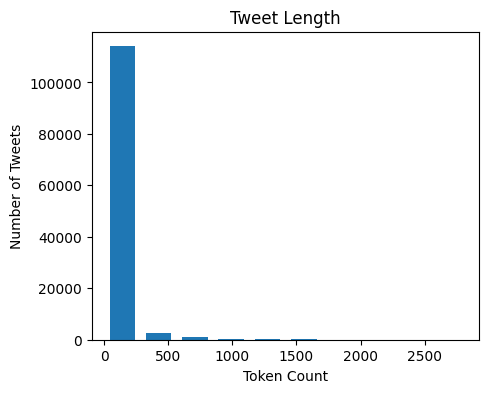

In [19]:
plt.hist([len(tweet) for tweet in train_df['text'].apply(lambda x: x.split())], rwidth = 0.7)
plt.title("Tweet Length")
plt.ylabel("Number of Tweets")
plt.xlabel("Token Count")
plt.show()

#### Preprocessing Data Labels

To keep it simple, I will just map the labels to integers.

In [20]:
labels = {'Non-Hateful': 0, 'Hateful': 1}
train_df['HOF'] = train_df['HOF'].apply(lambda x: labels[x])
test_df['HOF'] = test_df['HOF'].apply(lambda x: labels[x])

#### Dealing with biasness in class
The class imbalance in the data is a problem. Downsizing the majority to create a balance.

In [21]:
# Before the downsampling
print('Hateful: {}'.format(len(train_df[train_df['HOF'] == 1])))
print('Non-Hateful: {}'.format(len(train_df[train_df['HOF'] == 0])))

Hateful: 15057
Non-Hateful: 103004


In [22]:
# Downsampling
train_hateful = train_df[train_df['HOF'] == 1]
train_nonhateful = train_df[train_df['HOF'] == 0].sample(len(train_hateful))
train_downsample = pd.concat([train_hateful, train_nonhateful], axis = 0).sample(frac = 1)

In [23]:
# Sample of train_downsample
display(train_downsample.sample(20))

,text,HOF
27711,hahahahahahahahahahahahahahahahahaha vandalism...,1
17755,== will you ever stop vandalising body count...,0
7821,"Jesus Christ, I can't edit anything without s...",1
115221,"At the end of the day, Kudpung is a grade-A id...",1
59359,== Guess What?!?! == your retarded!,1
101112,` == Reason for moving title. == It is menti...,0
63130,::::::::Then we had a misunderstanding. Rleve...,0
34690,SHIT CUNT FUCK NIGGER CHINK,1
53329,== My sense of humour == I am inserting amu...,0
42164,you are a nazi asshole and always will be.,1


In [24]:
# Length of both classes data after downsampling
print('Hateful: {}'.format(len(train_downsample[train_downsample['HOF'] == 1])))
print('Non-Hateful: {}'.format(len(train_downsample[train_downsample['HOF'] == 0])))

Hateful: 15057
Non-Hateful: 15057


#### Split training data into train and dev sets

Not really required, but read somewhere that having a validating set is a good practice to have a better model.

I wanted to split the train and dev sets such that their proportion is almost like the train_downsample dataframe. Lot's of playing with the code. \
Resource used: https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn

In [25]:
from sklearn.model_selection import train_test_split
train, dev = train_test_split(train_downsample, test_size = 0.5, stratify = train_downsample['HOF'])

#### Data Preparation
So, before building of the model, the dataset needs to be changed into a format that is accepted by the BERT model.

Pipeline for cleaning and tokenizing the tweets will help. Using bert-base-uncased tokenizer so that the tokenizer matches the model. Handling of out-of-vocab words performed by the BERT tokenizer.

Usage of Dataset and DataLoader. \
Resource used: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html \
Resource for bert-case-uncased: https://huggingface.co/bert-base-uncased

##### Cleaning the text

In [26]:
def clean_text(tweet):
    tweet = tweet.lower()

    # Need to take care of @ mentions and URLs in the text
    tweet = re.sub(r"@[A-za-z0-9_-]+", "USR", tweet)
    tweet = re.sub(r"http\S+", "URL", tweet)

    tweet = tweet.replace("\n", " ")
    tweet = tweet.replace("[NEWLINE]", " ")
    tweet = tweet.replace("\t", " ")
    tweet = tweet.strip()

    return tweet


In [27]:
# BERT Dataset class that cleans, tokenizes, and encodes data
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel, BertTokenizer

class TweetDataset(Dataset):
    def __init__(self, data):
        # Bert Tokenizer Initialization
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        # Cleans, truncates and encodes tweets to max length 60. BERT's max is 512, max_length could be a hyperparameter.
        self.cleaned_tweets = data['text'].apply(lambda x: clean_text(x))
        self.tweets = list(self.cleaned_tweets.apply(self.tokenizer.encode, max_length = 60, truncation = True))
        self.labels = list(data['HOF'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        return tweet, label

In [28]:
BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=Path.cwd()/'venv/lib/site-packages/models--bert-base-uncased/')

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

#### Collate Function
Inexperience with BERT and searching through the internet; found out about collate_fn in DataLoader. Understanding the gist of the function, get a tuple if __getitem__ returns a tuple. \
Error: TypeError \
Not much clarity, but possibility of using padding. \
Felt easier to build a collate function with paddings applied to the tweets and creating mask tensors and padding them both.

In [29]:
# Collate Function to pass to DataLoader
def collate_bert(batch):
    batch_size = len(batch)

    tweets = [t for t, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()

    max_length = max(len(t) for t in tweets)

    tweets_pad = torch.zeros((batch_size, max_length)).long()
    masks_pad = torch.zeros((batch_size, max_length)).long()

    for idx, tweet in enumerate(tweets):
        tweets_pad[idx, :len(tweet)] = torch.tensor(tweet)
        masks_pad[idx, :len(tweet)] = 1

    return tweets_pad, masks_pad, labels

In [30]:
# Creating datasets
train_dataset = TweetDataset(train)
dev_dataset = TweetDataset(dev)
test_dataset = TweetDataset(test_df)

In [31]:
# Creating DataLoaders with torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size = 100, collate_fn = collate_bert, shuffle = True)
dev_loader = DataLoader(dev_dataset, batch_size = 100, collate_fn = collate_bert)
test_loader = DataLoader(test_dataset, batch_size = 100, collate_fn = collate_bert)

In [32]:
# Batches prepared
for (idx, batch) in enumerate(train_loader):
    print("Batch no. {}".format(idx))
    print("Encoded tweets count: {}".format(len(batch[0])))
    print("Encoded Tweets: ", batch[0])

    print("Encoded labels count: {}".format(len(batch[2])))
    print("Encoded Labels: ", batch[2])

Batch no. 0
Encoded tweets count: 100
Encoded Tweets:  tensor([[  101,  1024,  1024,  ..., 14695,  2018,   102],
        [  101,  2004,  1037,  ...,  8449,  2005,   102],
        [  101,  1024, 16948,  ...,  7578,  2451,   102],
        ...,
        [  101,  1036,  2001,  ...,  1036,   102,     0],
        [  101,  1027,  1027,  ...,     0,     0,     0],
        [  101,  1024,  4283,  ...,  3531,  4863,   102]])
Encoded labels count: 100
Encoded Labels:  tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 0])
Batch no. 1
Encoded tweets count: 100
Encoded Tweets:  tensor([[ 101, 1027, 1027,  ..., 2061, 2008,  102],
        [ 101, 1027, 1027,  ...,    0,    0,    0],
        [ 101, 1036, 3602,  ..., 2008, 2

#### Classification
With the datasets and dataloaders created successfully, hopefully correctly, now to build the model for the classification.

Resource Used: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613 \
BertModel Building Resource: https://huggingface.co/transformers/v2.5.0/_modules/transformers/modeling_bert.html

In [33]:
class classifier(nn.Module):

    def __init__(self):
        super(classifier, self).__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased', cache_dir = Path.cwd()/'venv/lib/site-packages/huggingface_hub/models--bert-case-uncased/')
        self.linearnn = nn.Linear(768, 4) # Network layer

        self.dropout = nn.Dropout(0.2)

        # Freezing BERT layers
        for n, p in self.model.named_parameters():
            p.requires_grad = False

    def forward(self, tweets, masks):
        # Flow of tensors 
        output_bert = self.model(tweets, attention_mask = masks)[0].mean(axis = 1) # Reminder: 'AXIS'
        return self.linearnn(self.dropout(output_bert))

In [34]:
# Model Initialization
model = classifier()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


So, the error above is apparently because the pretrained head of the BERT model was discarded and replaced with initialized classification model. Fine Tuning up ahead.

In [35]:
# Model to device
model = model.to(device)

In [36]:
# Optimizer, Objective function and epochs
optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
epochs = 5

In [37]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [38]:
# Training the model
for epoch in range(1, epochs):
    # Dropout Layers activation
    model.train()

    # Training in batches
    for idx, batch in enumerate(tqdm(train_loader)):
        # PyTorch accumulates gradients before performing backward prop.
        optimizer.zero_grad()
        # Batches and data to device.
        tweets, masks, labels = [t.to(device) for t in batch]
        # Forward Prop - just a model() call
        output = model(tweets, masks)
        # Loss Calculation
        loss = criterion(output, labels)
        # Backprop
        loss.backward()
        # Handling the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Step
        optimizer.step()

    # With each training epoch, measure performance on validation set
    model.eval()

    y_true = list()
    y_pred = list()

    with torch.no_grad():
        for batch in dev_loader:
            tweets, masks, labels = [tweet.to(device) for tweet in batch]
            output = model(tweets, masks)
            max_output = output.argmax(dim = 1)
            y_true.extend(labels.tolist())
            y_pred.extend(max_output.tolist())
    
    print("Accuracy after {} epochs: ".format(accuracy_score(y_true, y_pred)))

100%|██████████| 151/151 [00:25<00:00,  5.82it/s]


Accuracy after 0.85880321445175 epochs: 


100%|██████████| 151/151 [00:24<00:00,  6.12it/s]


Accuracy after 0.8455867702729627 epochs: 


100%|██████████| 151/151 [00:24<00:00,  6.09it/s]


Accuracy after 0.8621239290695357 epochs: 


100%|██████████| 151/151 [00:24<00:00,  6.09it/s]


Accuracy after 0.8663744437803015 epochs: 


In [39]:
# Model Evaluation on Test Data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for batch in test_loader:
        tweets, masks, labels = [tweet.to(device) for tweet in batch]
        output = model(tweets, masks)
        max_output = output.argmax(dim = 1)
        y_true.extend(labels.tolist())
        y_pred.extend(max_output.tolist())

print("Test accuracy: ", accuracy_score(y_true, y_pred))
print("Classification Report: ",  classification_report(y_true, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_true, y_pred))

Test accuracy:  0.7083333333333334
Classification Report:                precision    recall  f1-score   support

           0       0.96      0.71      0.81       541
           1       0.21      0.69      0.32        59

    accuracy                           0.71       600
   macro avg       0.58      0.70      0.57       600
weighted avg       0.88      0.71      0.77       600

Confusion Matrix: 
 [[384 157]
 [ 18  41]]


#### Baseline Comparisons

In [40]:
# Say we just predict all non-hatefuls.
y_pred = [0] * len(test_df)
y_true = test_df['HOF']
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       541
           1       0.00      0.00      0.00        59

    accuracy                           0.90       600
   macro avg       0.45      0.50      0.47       600
weighted avg       0.81      0.90      0.86       600



C:\Users\Ray Joshi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ray Joshi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ray Joshi\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le